# Estimating Epidemic models from observations

**Background**:
An important part of mathematical modeling is fitting models to observed data that is collected from a surveillance system.
Models can serve as tools to understand the mechanics of how a pathogen moves through one or more populations, used to produce forward-looking predictions about what may happen, or studied under different interventions to evaluate their potential usefulness.

We will take the following steps to understand how to fit a compartmental model to data 
1. Build a simulation that generates data from a SIR model. To understand how to fit a model we must first understand how a model could potentially generate our dataset.
2. Briefly remember how a linear regression model, $y \sim \mathcal{N}(\mu(x), \sigma^{2})$, is fit to data.
3. Apply the "sum squares error" approach in (2) to our compartmental model.
4. Generalize (2) and (3) to other data generating mechanisms with maximum likelihood estimation.   

Compartmental models can be thought of as functions from time and a set of parameters to a set of states over time or $f(t_{0},t_{1},t_{2}\cdots,t_{T}; \theta)$. 
For example, we can think of the SIR model as a function that takes as input times $t = [t_{0},t_{1},t_{2}, \cdots, t_{T}]$, two parameter values $\theta = (\beta, \gamma)$ and then outputs the proportion of susceptibles, infected, removed over time. 

\begin{align}
    t &= (t_{0}, t_{1}, \cdots, t_{T})\\
    \theta &= (3/2, 1/2)\\
    M &= \textrm{SIR}( t; \theta )
\end{align}

where $M$ is the matrix 

\begin{align}
    M = \begin{bmatrix}
    S_{0} & S_{1} & S_{2} & \cdots & S_{T} \\   
    I_{0} & I_{1} & I_{2} & \cdots & I_{T} \\
    R_{0} & R_{1} & R_{2} & \cdots & R_{T} \\
    i_{0} & i_{1} & i_{2} & \cdots & i_{T} \\
    \end{bmatrix}
\end{align}

Lets assume that we collect the number of incident infected cases over the times $t = [0,1,2,3,4,5,\cdots,10]$ and plot this as black circles (below). 

## Simulating data from a SIR model---Data Generating Process

Assume that the pathogen under study follows SIR dynamics. 

\begin{align}
    \dot{S} =  \frac{dS}{dt} &= -\beta S \frac{I}{N} \\ 
    \dot{I}  &=  \beta S \frac{I}{N} - \gamma I \\ 
    \dot{R}  &=  \gamma I \\ 
\end{align}

Then given a vector of parameters $\theta = (\beta, \gamma)$ and a tuple of initial condition we can estimate solutions $S(t),I(t),R(t)$.


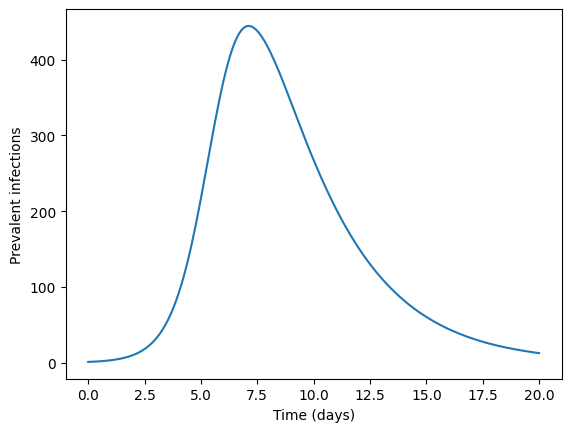

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

n = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma,n):
    s,i, r, c = y
    ds_dt = -beta*s*i/n
    di_dt = beta*s*i/n - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i/n            #--incident cases (why?)
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (999, 1, 0., 0)

#--parameters for the model 
beta, gamma = 3./2, 1./3

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma,n))
prevalent_infections = solution.y[1,:]
times                = solution.t 

plt.plot(times,prevalent_infections)
plt.xlabel("Time (days)")
plt.ylabel("Prevalent infections")
plt.show()

To generate data from this curve, we need to assume a data generating process.
A data-generating process is a proposed algorithm for how a dataset,$\mathcal{D}$, may have been observed.
A common DGP for prevalent infections from the SIR model is to assume each data point $y_{t}$ was produced by a corresponding random variable $( y_{1} \sim Y_{1},y_{2} \sim Y_{2},y_{3} \sim Y_{3},\cdots,y_{T} \sim Y_{T})$

For the below example, we assume that $Y_{t}$ is a Poisson random variable, i.e. $Y_{t} \sim \text{Poisson}( \lambda(t) )$ where the parameter value $\lambda(t) = I(t)$. To implement this DGP, for $t$ from 0,1,2,3,... to 20 we compute I(t) as we did in the above cell and then draw a value $y_{t}$ from a Poisson distribution where $\lambda$ equals the number of prevalent infections $I(t)$.  

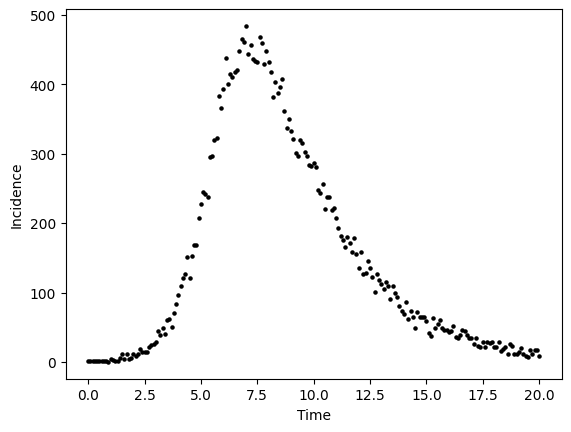

In [6]:
#--add poisson noise
noisy_prevalent_infections = np.random.poisson(prevalent_infections)

fig,ax = plt.subplots()
ax.scatter(times, noisy_prevalent_infections, s=5,color="black")

ax.set_xlabel("Time")
ax.set_ylabel("Incidence")

plt.show()

### Recap 

If we assume that this data is expected to follow SIR dynamics then we suppose two items: (i) that there exists a true SIR model and single set of parameter values $\theta$ that are used to generate the underlying true, never observed, number of prevalent cases and (ii) that there exists a sequence of random variables that use the output from our SIR model to generate the observed number of infections over time. 

We supposed above that the data above is generated by a sequence of Poisson random variables that depend on the number of incident cases at time 1, time 2, time 3, and so on

\begin{align}
    \mathcal{D} = (y_{1}, y_{2}, \cdots, y_{T})\\ 
    y_{1} \sim Y_{1}; \; y_{2} \sim Y_{2}; \; \cdots \; ; y_{T} \sim Y_{T};\\  
    Y_{1} \sim \textrm{Pois}(I_{1}) , Y_{2} \sim \textrm{Pois}(I_{2}), \cdots, Y_{t} \sim \textrm{Pois}(I_{t})\\
    I_{t} = \textrm{SIR}(t;\theta)
\end{align}

This means that different parameter values will lead to different underlying incident cases that may have generated our data.

## Fitting a linear regression model to data 

Suppose the following data generating process

\begin{align}
    \mathcal{D} &= (  (x_{1},y_{1}), (x_{2},y_{2}), (x_{3},y_{3}), \cdots, (x_{T},y_{T}))\\ 
    y_{t}  &\sim \mathcal{N}( \mu(t), \sigma^{2} ) \\
    \mu(t) &= \beta_{0} + \beta_{1}x_{t} \\ 
\end{align}

Lets use this DGP to generate a dataset. Then we will review linear regression fitting. 

          x          y
0 -4.000000 -14.415189
1 -3.919192  -7.604549
2 -3.838384  -8.784303
3 -3.757576  -5.996493
4 -3.676768  -7.107096


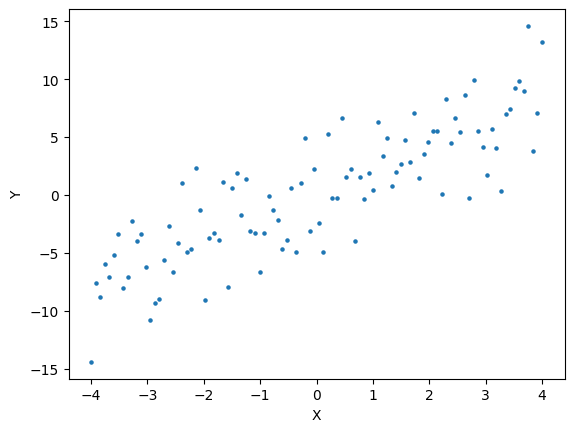

In [7]:
# parameter values, theta = (b0,b1,sigma)
b0    = 0.5
b1    = 2
sigma = 3

x = np.linspace(-4,4,100)
y = np.random.normal( b0 + b1*x, sigma)

plt.scatter(x,y,s=5)
plt.xlabel("X")
plt.ylabel("Y")

#--easy way to build a dataset in pandas
import pandas as pd 
d = pd.DataFrame({"x":x, "y":y})
print(d.head())

# Modeling Fitting 
(Parametric) model fitting is deciding, assuming our model is the true process that generated our data, which parameter values are most likely to have generated the observations that we have collected.

### Least squares
Suppose you are interested in values for a variable $y$ called your response given values of a variable $x$ called your 
A **parametric** model inputs a vector of values, called parameters, and returns a vector of estimated responses.
One way we may evaluate how well the parameter values ($\beta_{0}$, $\beta_{1}$) fits the data is with least squares. 

Given $y_{t} = \beta_{0} + \beta_{1}x_{t}$ and a set of parameter values $(\beta_{0}, \beta_{1})$, we can evaluate how well $(\beta_{0}, \beta_{1})$ fits the data by computing the average squared distance between the real data values $(y_{0},y_{1},\cdots,y_{n})$ and the model-outputted values $(\hat{y}_{0},\hat{y}_{1},\cdots,\hat{y}_{n})$. 

\begin{align}
    SSE(\beta_{0},\beta_{1}) &= \frac{1}{n} \sum_{i=0}^{n} \left( y_{i} - \hat{y_{i}} \right)^{2}\\
    \hat{y_{i}}              &= \beta_{0} + \beta_{1} x_{i}
\end{align}

For example, given $\theta = (0.5,1)$ we can compute 

In [8]:
def SSE(b0,b1,data):
    yhat = b0 + b1*data.x.values
    return np.mean( (yhat - data.y.values)**2 )
SSE(0.5,1,d)

14.873939692422791

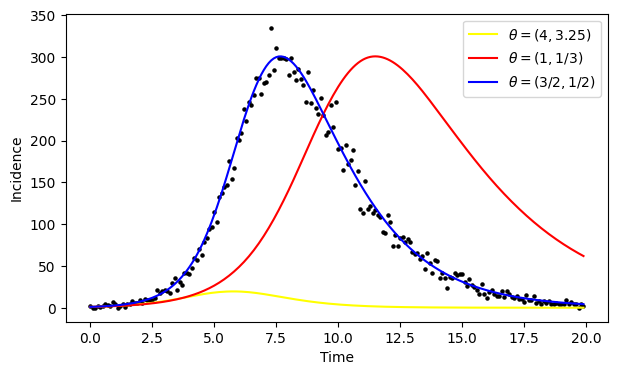

In [33]:
from scipy.integrate import solve_ivp

import numpy as np 
import matplotlib.pyplot as plt 

N = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma):
    s,i, r= y
    ds_dt = -beta*s*i/n
    di_dt = beta*s*i/n - gamma*i
    dr_dt = gamma*i
    
    return [ds_dt, di_dt, dr_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end,0.1)

#--inital conditions for s, i, r
initial_conditions = (999, 1, 0.)

#--parameters for the model 
beta, gamma = 3./2, 1./2


#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma))
times                = solution.t
prevalent_infections = solution.y[1]

#--add poisson noise
noisy_prevalent_infections = np.random.poisson(prevalent_infections)

def from_theta_to_I(beta,gamma, tvals, initial_conditions, start,end):
    solution = solve_ivp( fun = sir
                         , t_span = (start,end)
                         , y0     = initial_conditions
                         , t_eval = tvals
                         , args   = (beta, gamma))
    times                = solution.t
    prevalent_infections = solution.y[1]

    return times, prevalent_infections
    
fig,ax = plt.subplots(figsize = (7,4))
ax.scatter(tvals, noisy_prevalent_infections, s=5,color="black")

times, I = from_theta_to_I(4,3.25,tvals,initial_conditions,start,end)
ax.plot(times, I, color="yellow", label = r"$\theta = (4, 3.25)$")

times, I = from_theta_to_I(1,1./3,tvals,initial_conditions,start,end)
ax.plot(times, I, color="red", label = r"$\theta = (1, 1/3)$")

times, I = from_theta_to_I(3/2,1/2,tvals,initial_conditions,start,end)
ax.plot(times, I, color="blue", label = r"$\theta = (3/2, 1/2)$")

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Incidence")

plt.show()

Model fitting is deciding, assuming our model is the true process that generated our data, which parameter values are most likely to have generated the observations that we have collected.

The first step to building a model fit is to validate our model. 

Validating a model consists of three steps:
1. Propose an algorithm for identifying the parameter values that generated the data
2. Develop a simulation that uses this model, and user specific parameter values, to generate a dataset
3. Apply the proposed fit algorithm to the simulated data to see if this algorithm can recover the true parameter values. 

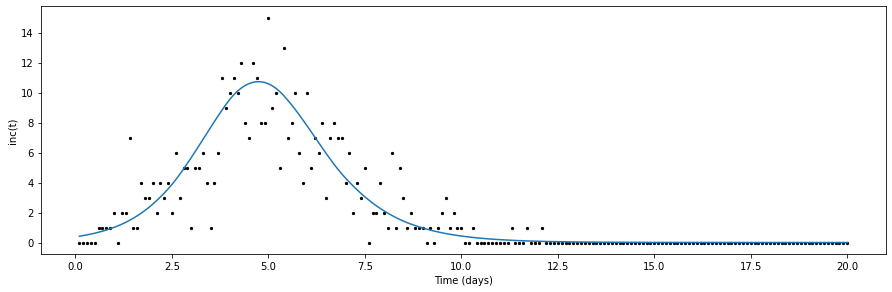

In [193]:
#--import packages
from scipy.integrate import solve_ivp

import numpy as np 
import matplotlib.pyplot as plt 

N = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma):
    s,i, r, c = y
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i #--incident cases
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 20

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (0.999, 0.001, 0., 0.001)

#--parameters for the model 
beta, gamma = 4, 1./(1./3)

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma))

#--extract from the solution object the times and a matrix of the three states
times  = solution.t
sir    = solution.y

#--compute incident cases
inc_cases = N*np.diff(sir[3,:])

#--add poisson noise
noisy_inc_cases = np.random.poisson(inc_cases)

#--draw i(t)
fig, ax = plt.subplots()
fig.set_size_inches(12.5,12.5/3)

ax.plot(   times[1:] ,inc_cases)
ax.scatter(times[1:] ,noisy_inc_cases, s=5, color="black")

#--set y and xlabel 
ax.set_xlabel("Time (days)", fontsize=10)
ax.set_ylabel("inc(t)", fontsize=10)

fig.set_tight_layout(True) #--adjust graph to fit labels

#--show the plot (not needed but is nice to include)
plt.show()

Lets print out this dataset called `noisy_inc_cases`

In [194]:
print(noisy_inc_cases)

[ 0  0  0  0  0  1  1  1  1  2  0  2  2  7  1  1  4  3  3  4  2  4  3  4
  2  6  3  5  5  1  5  5  6  4  1  4  6 11  9 10 11 10 12  8  7 12 11  8
  8 15  9 10  5 13  7  8 10  6  4 10  5  7  6  8  3  7  8  7  7  4  6  2
  4  3  5  0  2  2  4  2  1  6  1  5  3  1  2  1  1  1  0  1  0  1  2  3
  1  2  1  1  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


The input to our "fit algorithm" is the above sequence of observed incident cases. 
The output to our algorithm needs to be a tuple of parameter values $\theta = (\beta, \gamma)$ such that these parameter values are the most likely to have generated the above sequence of values. 

## Maximum likelihood estimation (MLE)

The first algorithm that we will use is **maximum likelihood estimation**. 
MLE assigns a probability to each of the above observations that depends on the parameters $\theta = (\beta, \gamma)$ and maximizes the loglikelihood (proportional to the probability assigned to the dataset). 

**Setup**:
Suppose that we are handed a dataset of the number of incident cases which was collected over time from a surveillance system $\mathcal{D} = (y_{1},y_{2}, \cdots y_{t})$.
We can assume that this data was generated i.i.d from a sequence of Poisson distributed random variables 
$(Y_{1}, Y_{2}, \cdots, Y_{t})$ where 

\begin{align}
    Y_{i} \sim \textrm{Poisson}(\lambda(t))
\end{align}

and 

\begin{align}
    \lambda(t) = \textrm{inc}(t)
\end{align}

That is, if we knew the true number of incident cases at time $0,1,2,\cdots, T $ then we could compute the loglikelihood.

To compute the loglikelihood we will need to take the logarithm of the probability mass function for a poisson distributed random variable. 
The probability mass function (pmf) for a poisson distributed random variable $Y$ is 

\begin{align}
    P(Y=y) = e^{\lambda} \frac{\lambda^{y}}{y!}
\end{align}

The logarithm of the above pmf is 

\begin{align}
    \log \left[P(Y=y)\right] &= \log\left[e^{-\lambda} \frac{\lambda^{y}}{y!} \right]\\
                             &= -\lambda + y\log(\lambda) - \log(y!)
\end{align}

and so given parameters $(\lambda(1),\lambda(2), \cdots, \lambda(t) )$ the log likelihood for $t$ data points is 

\begin{align}
    \ell \ell (\lambda) &= \log \left [ P(y_{1}, y_{2}, \cdots, y_{t})  \right]   \\ 
    &= \log \left [ P(y_{1}) P(y_{2}) \cdots P(y_{t})  \right]  \; & \textrm{independence} \\ 
    &= \log \left [ P(y_{1})\right] +  \log \left [P(y_{2}) \right] + \cdots +  \log \left [P(y_{t}) \right]  \; & \textrm{log rules} \\ 
    &=  \sum_{i=1}^{t}\log \left [ P(y_{i})\right] \\ 
    &=  \sum_{i=1}^{t} -\lambda_{i} + y_{i}\log(\lambda_{i}) - \log(y_{i}!) \\ 
    \ell \ell (\lambda) &=  \sum_{i=1}^{t} -\lambda_{i} + y_{i}\log(\lambda_{i})  & \textrm{lambda does not impact y factorial} \\ 
\end{align}

The above $\lambda_{i}$ values are our incident cases generated by from our SIR model. 

\begin{align}
    \ell \ell (\lambda) &=  \sum_{i=1}^{t} -\lambda_{i} + y_{i}\log(\lambda_{i}) \\ 
    &= \sum_{i=1}^{t} -\textrm{inc}(i) + y_{i}\log(\textrm{inc}(i))
\end{align}

Our goal then is to find the parameters $\theta = (\beta, \gamma)$ that maximize the loglikelihood or 

\begin{align}
    \max_{\theta} \ell \ell (\theta | \mathcal{D}) 
\end{align}

Instead of maximizing the loglikelihood we can equivalently minimize the **negative** loglikelihood. 

\begin{align}
    \max_{\theta} \ell \ell (\theta | \mathcal{D}) = \min_{\theta} -\ell \ell (\theta | \mathcal{D}) 
\end{align}

We can use a function called `minimize` from `scipy.optimize` to minimize the negative loglikelihood. 
Documentation for the minimize function is here = [https://docs.scipy.org/doc/scipy/tutorial/optimize.html](https://docs.scipy.org/doc/scipy/tutorial/optimize.html). 

The minimize function takes two required arguments:
- A function to minimize (for us the negative loglikelihood) that takes as input a vector of parameters (for us this is beta and gamma)
- A starting point for the parameters values that we wish to optimize.
- We will also provide this function an optional argument called `args` and will input into this argument our data, a vector of incident cases. 

If we supply the above three items then the minimize function will return the parameter values that minimize `fun`. 

The above would be easy to compute if we had a function that directly maps parameter values $\theta = (\beta, \gamma)$ to a sequence of incident cases. 
However, inbetween our parameter values $\theta = (\beta, \gamma)$ and the proposed number of incident cases is a system of differential equations that we need to solve. 
That is, the sequence of values $\textrm{inc}(0),\textrm{inc}(1),\textrm{inc}(2), \cdots, \textrm{inc}(T)$ is computed from our SIR model.

We will need to
1. Build a function that takes as input parameter values and returns the number of incident cases
2. Write a function to compute the negative loglikelihood
3. Combine (1.) and (2.) so that we can minimize the negative loglikelihood for parameters $\theta = (\beta,\gamma)$.

In [195]:
from scipy.optimize import minimize #--import minimize function 

### First we should bundle our SIR model so that we input parameters and return (output) incident cases.

Our first function will copy/paste our code from the previous lab that takes $(\beta,\gamma)$, the number of individuals in the system $(N)$, initial conditions $(S_{0}, I_{0}, R_{0})$, and a start time and end time. 

In [196]:
def generate_proposed_inc_cases(beta_gamma, N, initial_conditions, start_end):
    import numpy as np 
    from scipy.integrate import solve_ivp
        
    #--SIR differential equations
    def sir(t,y, beta, gamma):
        s,i, r, c = y
        
        ds_dt = -beta*s*i
        di_dt =  beta*s*i - gamma*i
        dr_dt =  gamma*i

        dc_dt = beta*s*i #--incident cases
        return [ds_dt, di_dt, dr_dt, dc_dt]
    
    #--lets assume we will always want step sizes of 0.1
    start,end = start_end
    tvals = np.arange(start, end+0.1, 0.1)
    
    #--parse arguments from function 
    beta,gamma = beta_gamma

    #--function to return s,i,r over time
    solution = solve_ivp(     fun = sir
                         , t_span = (start,end)
                         , y0     = initial_conditions
                         , t_eval = tvals
                         , args   = (beta, gamma))

    #--extract from the solution object the times and a matrix of the three states
    times  = solution.t
    sir    = solution.y

    #--compute incident cases
    inc_cases = N*np.diff(sir[-1,:])
    return inc_cases

Lets test the above function by providing parameter values and observing that the output is a list of the number of incident cases. 

(0.0, 20.0)

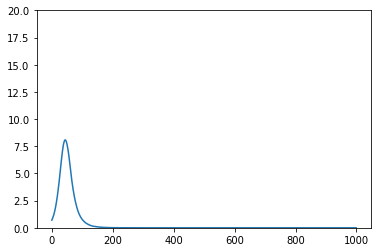

In [197]:
N=500
start_end = (0,100)
beta_gamma = (3./2, 1./2)
initial_conditions = (0.900, 0.01, 0.0, 0.01)

incident_cases = generate_proposed_inc_cases(beta_gamma, N, initial_conditions, start_end)
plt.plot(incident_cases)
plt.ylim(0,20)

#### Second the function to compute the negative loglikelihood 

Lets create our function that takes as input a sequence $(\lambda_{1},\lambda_{2},\cdots,\lambda_{T})$ a sequence of observations $(d_{1},d_{2},\cdots,d_{T})$ and returns the negative loglikelihood 

\begin{align}
    n\ell \ell (\lambda) &= -1 \cdot \left(\sum_{i=1}^{t} -\lambda_{i} + d_{i}\log(\lambda_{i})\right)
\end{align}



In [198]:
def nll(lambdas, data):
    import numpy as np 
    
    #--im adding a small positive number (eps) to our data and lambda incase any of these values are zero. 
    data    = data    + np.finfo(float).eps
    lambdas = lambdas + np.finfo(float).eps
    
    #--computelog likelihood
    ll = -1.*np.sum(lambdas) + np.sum(data*np.log(lambdas))
    
    return float(-1*ll) #--return the negative log likelihood

We can simulate some data from our SIR model assuming that our incident cases generate observations that follow a Poisson distribution and then explore the negative loglikelihood for different values of $\beta$, holding $\gamma$ constant. 

### Data simulation

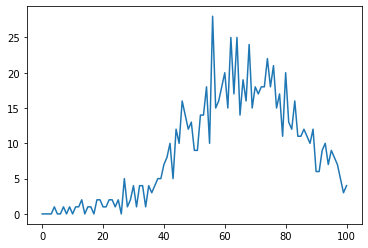

In [199]:
from scipy.integrate import solve_ivp

import numpy as np 
import matplotlib.pyplot as plt 

N = 1000 #--number of animals in system 

#--SIR differential equations
def sir(t,y, beta, gamma):
    s,i, r, c = y
    ds_dt = -beta*s*i
    di_dt = beta*s*i - gamma*i
    dr_dt = gamma*i
    
    dc_dt = beta*s*i #--incident cases
    return [ds_dt, di_dt, dr_dt, dc_dt]

#--start and end times 
start,end = 0., 10

#--times that we want to return s(t), i(t), r(t)
tvals = np.arange(start,end+0.1,0.1)

#--inital conditions for s, i, r
initial_conditions = (0.999, 0.001, 0., 0.001)

#--parameters for the model 
beta, gamma = 3./2, 1./2

#--function to return s,i,r over time
solution = solve_ivp( fun = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , t_eval = tvals
                     , args   = (beta, gamma))
incidence = np.append( 0.0001, np.diff(solution.y[-1,:]) )

#--add poisson noise
noisy_inc = np.random.poisson(incidence*N)

plt.plot(noisy_inc)

#### Lets generate a potential sequence of incident cases from our function `generate_proposed_inc_cases`

We can see how our algorithm will work by generating a few differnet sequences of incident cases and then computing the negative loglikelihoods for each.  

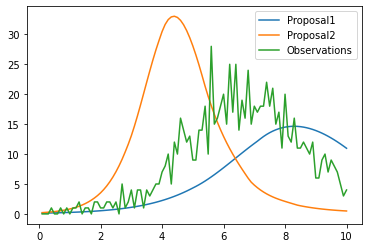

In [200]:
times = np.arange(0,10+0.1,0.1)

N=1000
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end = (0,10.)

beta_gamma = (1.25, 0.5)
incident_cases1 = generate_proposed_inc_cases(beta_gamma, N, initial_conditions, start_end)

beta_gamma = (2.0, 0.5)
incident_cases2 = generate_proposed_inc_cases(beta_gamma, N, initial_conditions, start_end)


plt.plot(times[1:],incident_cases1, label="Proposal1")
plt.plot(times[1:],incident_cases2, label="Proposal2")

plt.plot(times[1:],noisy_inc[1:], label="Observations")

plt.legend()

In [201]:
nll(incident_cases1, noisy_inc[1:])

-1167.2183259745761

In [202]:
nll(incident_cases2, noisy_inc[1:])

-632.547970205482

**QSA: Which proposal is better and why?**

We can compute the negative loglikelhood for a large range of $\beta$ and $\gamma$ values to visualize our goal: to find the pair of beta and gamma that lead to the smallest negative log likelihood (largest log likelihood).

In [203]:
all_nlls = []

betas  = np.linspace(1./2, 4, 100)
gammas = np.linspace(1./2, 4, 100)

for beta in betas:
    row = [] 
    for gamma in gammas:
        beta_gamma     = (beta,gamma)
        incident_cases = generate_proposed_inc_cases(beta_gamma, N, initial_conditions, start_end)
        m = nll(incident_cases,noisy_inc[1:])
        
        row.append(m)
    all_nlls.append(row)
all_nlls = np.array(all_nlls)

<ipython-input-198-0940dd769fe9>:9: RuntimeWarning: invalid value encountered in log
  ll = -1.*np.sum(lambdas) + np.sum(data*np.log(lambdas))


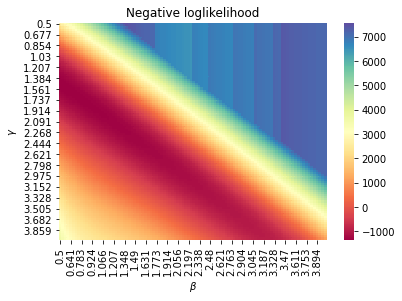

In [204]:
import pandas as pd 

all_nlls = pd.DataFrame(all_nlls)
all_nlls.index   = np.round(betas,3)
all_nlls.columns = np.round(gammas,3)

fig, ax = plt.subplots()

sns.heatmap(all_nlls.fillna( np.max(all_nlls) ), cmap="Spectral" , ax=ax)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")

ax.set_title("Negative loglikelihood")

plt.show()

It looks like there is more than one pair of beta and gamma that lead to a minimum negative likelihood. 
There is a band of red from top left to bottom right of $\theta = (\beta, \gamma)$ pairs that lead to the smallest loglikelihood.
This problem is called **non-identifiability**---when many pairs of parameter values map may be responsible four our observed dataset. 
Non-identifiability is bad. 

How should we approach this problem?

A common approach is to try and fix one of the parameter values based on external information so that the problem becomes identifiable. 

Back to our code and combining the function that generates incident cases and the function that computes the negative loglikelihood.
One approach to minimization is to enumerate many possible parameter values and then pick the pair of parameter values that leads to the smallest negative loglikelihood. This is called minimization by enumeration. 
This approach is ok so long as (i) you know the feasible ranges of all your parameters and (ii) you have suffucient computing power to generate a negative loglikelihood for all possible combinations of parameter values. 

#### Now we need to combine these two pieces together to minimize the negative log likelihood. 

We will create a function called `fit_model` that takes as input all of the parameters that we need for the function `proposed_incident_cases` and for the function `nll`. The output will be the negative loglikelihood. 
This function `fit_model` can be entered as an argument to the minimize function to find the $\beta, \gamma$ that leads to the smallest negative loglikelihood. 

In [205]:
def fit_model(beta_gamma         #--this is the argument that minimize will change and maximize 
             ,N
             ,inital_conditions  #--this argument and the one below are needed
             ,start_end
             ,data ):
    proposed_incident_cases = generate_proposed_inc_cases(beta_gamma,N, inital_conditions, start_end)
    return nll(proposed_incident_cases, data)

N                  = 1000 
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end          = (0,10) 
data               = noisy_inc[1:]+1 #--cutoff the first value 

results = minimize(fit_model
         ,x0   = (1.1,1.)
         ,args = ( N, initial_conditions, start_end, data )
         ,options = {"maxiter":500}
        )
print(results)

estimated_beta, estimated_gamma = results.x

      fun: -1504.9257496342118
 hess_inv: array([[0.00432261, 0.00144087],
       [0.00144087, 0.00048029]])
      jac: array([ 0.0002594 , -0.00016785])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 75
      nit: 11
     njev: 25
   status: 2
  success: False
        x: array([1.43231441, 0.43600308])


We see that the output to the minimize function is an object with many attributes. 
The attribute `results.x` is an array that invludes the $\beta, \gamma$ that leads to the smallest negative loglikelhood. 
The negative logliklihood corresponding to this result is stored in the attirubte `results.fun`. 

Lets compare how well our maximum likelihood estimate compares to the truth. 
We can plot the true number of incident cases, poisson distributed data, and then an SIR model that is generated from our estimated beta and estimatd gamma. 

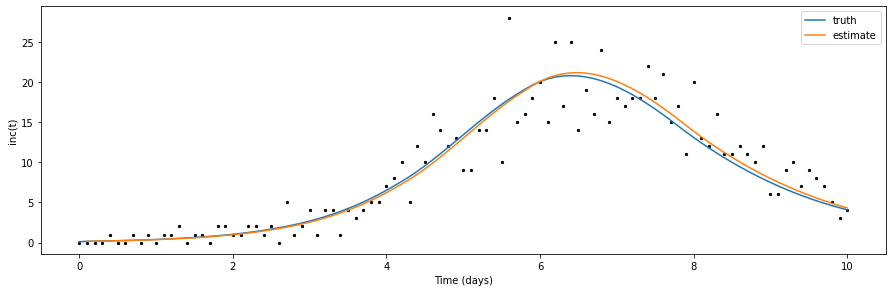

In [206]:
#--estimated incident cases
N                  = 1000 
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end          = (0,10) 

estimated_parameters = (estimated_beta, estimated_gamma)
estimated_inc_cases  = generate_proposed_inc_cases(estimated_parameters, N, initial_conditions, start_end)

#--draw i(t)
fig, ax = plt.subplots()
fig.set_size_inches(12.5,12.5/3)

ax.plot(times   ,N*incidence, label="truth")
ax.scatter(times,noisy_inc, s=5, color="black")

ax.plot(times[1:]   ,estimated_inc_cases, label="estimate")

ax.legend()

#--set y and xlabel 
ax.set_xlabel("Time (days)", fontsize=10)
ax.set_ylabel("inc(t)", fontsize=10)

fig.set_tight_layout(True) #--adjust graph to fit labels

plt.show()

#### HOMEWORK PROBEM 1

Please use the code above and reparameterize our SIR model so that we input the parameters $\mathcal{R}_{0}$ and $1/\gamma$ instead of the parameters $\beta$ and $\gamma$.
You will need to modify only the function `generate_proposed_inc_cases` to input $\mathcal{R}_{0}$ and $1/\gamma$. 
Lets change the argument `beta_gamma` to `R0_duration`.

Generate noisy incident cases for the following setting:
- initial_conditions = (0.99, 0.10, 0.00, 0.10)
- $\mathcal{R}_{0} = 2.75$ , $1 / \gamma = 2$, and $N=1000$
- start = 0 and end = 15

#### HOMEWORK PROBLEM 2

Now that you can create a sequence of incident cases that depends on $\mathcal{R}_{0}$ and $1/\gamma$, lets fit our SIR model to the noisy incident cases that you generated in HW Problem One.  
Plot the true number of incident cases, noisy observations, and estimated number of incident cases. 

#### HOMEWORK PROBLEM 3

The last assignment will be to add an additional parameter to our model---$I(0)$.
Up until now we have assumed that we know the initial conditions exactly. 
Lets modify our code so that we estimate $\mathcal{R}_{0}$, $1 / \gamma$, and an additional parmaeter $I(0)$.

This means that we will not longer need to give our model fit initial conditions, our initial conditions are now a variable that needs to be optimized. 
We will assume that our initial conditions are $S(0) = 1 - I(0)$, $I(0)$, and $R(0) = 0$. 


Our new parameter $I(0)$ that we will introduce can cause some trouble for the `minimize` function---the variable I(0) can only be between the values 0 and 1. The variable $I(0)$ has **constraints**. 
To overcome this problem we will need to work with a **transformed version** of $I(0)$. 

Our minimization will choose values $\beta$, $\gamma$, and a variable $a$ such that values of $a$ are unconstrained and map to potential values of the initial proportion of infections $I(0)$. 

Our variable $a$ must map values rom $(-\infty,\infty)$ to $[0,1]$.
The minimization program will test values on the interval $(-\infty,\infty)$ and it will be our job to map those valus to the interval $[0,1]$. 

We know a function that can map real values to the interval zero to one! The logistic function. 

\begin{align}
    l(x) = \frac{ e^{x} }{1 + e^{x}}
\end{align}

1. Update the function `generate_proposed_inc_cases`
    - Remove the inital_conditions argument
    - Change the parameter argument `R0_duration` to `R0_duration_transformedi0`
    - Compute initial conditions inside this function given the above variable `R0_duration_transformedi0`
        - Be sure to map the transformedi0 value to the interval [0,1] using the logistic function.   
2. Fit your model to the data. What happened? 